In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import os


try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted):
    # Both should be pre-sorted arrays
    return np.mean((u_sorted - v_sorted)**2) # square is built in

def assignment_sliced_wasserstein(X, Y, AX, BY):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            # positive‐sign cost (both arrays already ascending)
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            # negative‐sign cost: reverse the sorted array before negating
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C[i, j] = min(d_pos, d_neg)
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    return np.sqrt((1 / k) * total_cost)
 # to hopefully be a pseudometric - regardless, matching units

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if X.shape[1] != Y.shape[1]: # need to live in same dimensional space
        raise ValueError(f"OT: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=10000, tol=1e-6, verbose=False):
    """
    Find the best orthogonal R (no scaling) and permutation π so that Xc ≈ (Yc @ R)[π].
    Returns the sum of squared distances under that R + π.
    """
    # 1) center both clouds
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # 2) start with the identity matching
    π = np.arange(n)
    cost_prev = np.inf

    for it in range(max_iter):
        # ─── Step 1: find the orthogonal rotation R (no scale) that best aligns Yc[π] → Xc ───
        R, _ = orthogonal_procrustes(Yc[π], Xc)
        Yc_rot = Yc @ R   # *** drop any scale ***

        # ─── Step 2: re‐compute the one‐to‐one assignment under the new rotation ───
        C = cdist(Xc, Yc_rot, metric='sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()

        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")

        # check convergence
        if abs(cost - cost_prev) < tol:
            break

        cost_prev = cost
        π = col_ind

    # ─── Final transform (pure rotation + centroid shift) ───
    R, _ = orthogonal_procrustes(Yc[π], Xc)
    Yc_aligned = Yc @ R
    # add back X’s centroid
    Y_aligned = Yc_aligned + X.mean(axis=0)

    return cost, (Y_aligned, R, π)


def procrustes_ot(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Procrustes: Shape mismatch {X.shape} vs {Y.shape}")
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError(f"SW: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0), 
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0), 
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)), 
        dict(mean=np.ones(2)), 
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_diffusion_grid(X, Y, k_values, t_values, distance_fn):
    results = {}
    for k in k_values:
        for t in t_values:
            try:
                t0 = time.time()
                AX = diffusion_embedding(X, k=k, t=t)
                BY = diffusion_embedding(Y, k=k, t=t)
                # Optionally rescale to match variance for fair distance comparison
                # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
                scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
                AX *= scale
                BY *= scale
                dist = distance_fn(X, Y, AX, BY)
                t1 = time.time()
                results[(k, t)] = (dist, t1 - t0)
            except Exception as e:
                results[(k, t)] = (str(e), None)  # capture any errors
    return results

def test_sliced_wasserstein_proj(X, Y, n_proj_values, seed=None):
    results = {}
    for n_proj in n_proj_values:
        try:
            t0 = time.time()
            dist = sliced_wasserstein(X, Y, n_proj=n_proj, p=2, seed=seed)
            t1 = time.time()
            results[n_proj] = (dist, t1 - t0)
        except Exception as e:
            results[n_proj] = (str(e), None)
    return results

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    # Grid parameters
    k_values = [10]
    t_values = [0, 1, 10]
    n_proj_values = [100, 1000, 10000]

    rows = []
    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        n = 3500
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])

        # PCA embedding baseline
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        # Scale PCA embeddings to match input variance - heuristic
        # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale
        BY *= scale
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion embedding grid (k, t)
        diffusion_results = test_diffusion_grid(
            X, Y, k_values=k_values, t_values=t_values,
            distance_fn=assignment_sliced_wasserstein
        )

        # Sliced Wasserstein with varying n_proj (standard)
        sw_proj_results = test_sliced_wasserstein_proj(
            X, Y, n_proj_values=n_proj_values, seed=42
        )

        # GW, OT, Procrustes
        t0 = time.time()
        d_gw = gromov_wasserstein(X, Y)
        t1 = time.time()
        gw_time = t1 - t0

        try:
            t0 = time.time()
            d_ot = standard_ot(X, Y)
            t1 = time.time()
            ot_time = t1 - t0
        except ValueError as e:
            d_ot = str(e)
            ot_time = None

        try: 
            t0 = time.time()
            d_proc = procrustes_ot(X, Y)
            t1 = time.time()
            procrustes_time = t1 - t0
        except ValueError as e:
            d_proc = str(e)
            procrustes_time = None

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})')
        print(f'   SlicedWasserstein-PCA:   {d_pca:.4g} (time: {pca_time:.2f}s)' if pca_time is not None else '   SlicedWasserstein-PCA:   Error')
        print(f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)' if gw_time is not None else '   Gromov-Wasserstein:      Error')
        print(f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)' if ot_time is not None else '   Standard OT:             Error')
        print(f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)' if procrustes_time is not None else '   Procrustes OT:           Error')
        print('   --- Diffusion grid (assignment SlicedWasserstein) ---')
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            print(f'      k={kk:3d}, t={tt:2d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      k={kk:3d}, t={tt:2d}: Error')
        print('   --- Standard Sliced Wasserstein by n_proj ---')
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            print(f'      n_proj={n_proj:4d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      n_proj={n_proj:4d}: Error')
        print()
        row = {
            'A_type': dtype1,
            'A_params': str(p1),
            'B_type': dtype2,
            'B_params': str(p2),
            'sliced_pca': d_pca,
            'sliced_pca_time': pca_time,
            'gromov_wasserstein': d_gw,
            'gromov_wasserstein_time': gw_time,
            'standard_ot': d_ot,
            'standard_ot_time': ot_time,
            'procrustes_ot': d_proc,
            'procrustes_ot_time': procrustes_time,
        }
        # Add diffusion results
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            row[f'diffusion_k{kk}_t{tt}'] = dist
            row[f'diffusion_k{kk}_t{tt}_time'] = t_elapsed
        # Add SW projections
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            row[f'sw_proj{n_proj}'] = dist
            row[f'sw_proj{n_proj}_time'] = t_elapsed
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv('all_scores_per_pair.csv', index=False)

if __name__ == '__main__':
    test_framework()

ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

Pairwise tests (cartesian product):



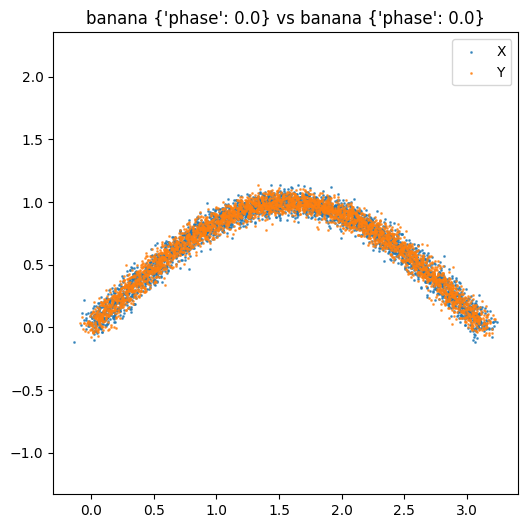

KeyboardInterrupt: 

In [ ]:
def compute_distance_matrix(distance_fn, embedding_fn, k=2, out_path="distance_matrix.csv"):
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    labels = []

    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))
            labels.append(f"{dtype}_{str(params)}")

    n = 5
    dist_matrix = np.zeros((len(configs), len(configs)))

    for i, (dtype1, p1) in enumerate(configs):
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        AX = embedding_fn(X, k)
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale

        for j, (dtype2, p2) in enumerate(configs):
            if j < i:
                dist_matrix[i, j] = dist_matrix[j, i]
                continue

            Y = generate_dataset(dtype2, n=n, d=2, **p2)
            BY = embedding_fn(Y, k)
            scale = np.sqrt(np.trace(np.cov(Y.T)) / np.trace(np.cov(BY.T)))
            BY *= scale

            try:
                dist = distance_fn(X, Y, AX, BY)
            except Exception as e:
                print(f"Error between {labels[i]} and {labels[j]}: {e}")
                dist = np.nan

            dist_matrix[i, j] = dist

    df = pd.DataFrame(dist_matrix, index=labels, columns=labels)
    df.to_csv(out_path)
    print(f"Saved distance matrix to {os.path.abspath(out_path)}")

    return df

def check_triangle_inequality(df):
    D = df.values
    labels = df.index.tolist()
    n = len(D)

    violations = []
    max_violation = 0.0

    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i == j or j == k or i == k:
                    continue
                lhs = D[i, k]
                rhs = D[i, j] + D[j, k]
                if not np.isnan(lhs) and not np.isnan(rhs) and lhs > rhs + 1e-8:
                    violation_amt = lhs - rhs
                    violations.append((labels[i], labels[j], labels[k], violation_amt))
                    max_violation = max(max_violation, violation_amt)

    print(f"\nChecked {len(violations)} triangle inequality violations.")
    if violations:
        print(f"Max violation: {max_violation:.6f}")
        print("Examples:")
        for a, b, c, v in sorted(violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("All triangles satisfied the triangle inequality.")

    return violations

def filter_2d_only_violations(violations):
    def is_2d(label):
        return not label.startswith("cylinder")

    pure_2d_violations = [
        (a, b, c, v) for (a, b, c, v) in violations
        if is_2d(a) and is_2d(b) and is_2d(c)
    ]

    print(f"\nTriangle inequality violations among only 2D datasets: {len(pure_2d_violations)}")
    if pure_2d_violations:
        max_violation = max(pure_2d_violations, key=lambda x: x[3])[3]
        print(f"Max 2D-only violation: {max_violation:.6f}")
        for a, b, c, v in sorted(pure_2d_violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("✅ No triangle inequality violations among 2D-only datasets.")

    return pure_2d_violations

if __name__ == '__main__':
    #df = compute_distance_matrix(
    #    distance_fn=assignment_sliced_wasserstein,
    #    embedding_fn=lambda X, k: diffusion_embedding(X, k=k, t=1),  # you can change t=1 to other values
    #    k=10000000000000,
    #    out_path="shape_distances_diffusion_t1.csv"
    #)

    #violations = check_triangle_inequality(df)
    #filter_2d_only_violations(violations)

    df = compute_distance_matrix(
        distance_fn=assignment_sliced_wasserstein,
        embedding_fn=pca_embedding,
        k=2,
        out_path="shape_distances_pca.csv"
    )

    violations = check_triangle_inequality(df)
    filter_2d_only_violations(violations)


Saved distance matrix to c:\Users\zakkh\PAIRSWEEP\shape_distances_pca.csv

Checked 188 triangle inequality violations.
Max violation: 2.706902
Examples:
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, cylinder_{'angle': 0.0}) + D(cylinder_{'angle': 0.0}, swissroll_{}) by 2.706902
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, cylinder_{'angle': 0.0}) + D(cylinder_{'angle': 0.0}, normal_{'mean': array([1., 1.])}) by 2.706902
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, swissroll_{}) by 2.527591
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, normal_{'mean': array([1., 1.])}) by 2.527591
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, cylinder_{'angle': 1.570796326794

In [ ]:
import numpy as np
import time
import pandas as pd

def perturb_points(X, kind='gaussian', magnitude=0.1):
    """Add isotropic Gaussian noise (or other) to a point cloud."""
    if kind == 'gaussian':
        return X + magnitude * np.random.randn(*X.shape)
    # You can add other perturbation types here.
    raise NotImplementedError(f"Perturbation kind '{kind}' not implemented.")

def eval_metric_relative_change(metric_fn, X, Y, n_trials=30, perturb_kind='gaussian', magnitude=0.1, **metric_kwargs):
    """Run repeated trials for a metric, return relative normalized changes, SNR, total time."""

    # --- Center X and Y before running any metric ---
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)

    # Compute baseline distance (unperturbed)
    t0 = time.time()
    D_baseline = metric_fn(X_centered, Y_centered, **metric_kwargs)
    t1 = time.time()
    baseline_time = t1 - t0

    rel_changes = []
    times = []

    for i in range(n_trials):
        X_pert = perturb_points(X, kind=perturb_kind, magnitude=magnitude)
        X_pert_centered = X_pert - X_pert.mean(axis=0)  # <--- recenter after perturbing
        t0 = time.time()
        D_pert = metric_fn(X_pert_centered, Y_centered, **metric_kwargs)
        t1 = time.time()
        times.append(t1 - t0)
        if np.abs(D_baseline) > 1e-10:
            rel_change = np.abs((D_pert - D_baseline) / D_baseline)
        else:
            rel_change = np.nan # Avoid division by zero
        rel_changes.append(rel_change)

    rel_changes = np.array(rel_changes)
    mean_rel_change = np.nanmean(rel_changes)
    std_rel_change = np.nanstd(rel_changes)
    snr_a = mean_rel_change / std_rel_change if std_rel_change > 1e-12 else np.nan
    total_time = baseline_time + np.nansum(times)

    return {
        'mean_rel_change': mean_rel_change,
        'std_rel_change': std_rel_change,
        'snr_a': snr_a,
        'total_time': total_time,
        'D_baseline': D_baseline,
        'rel_changes': rel_changes,
    }


# --- Plug in your algorithms here. Each must be a function metric(X, Y, ...) ---

def metric_pca(X, Y):
    k = min(X.shape[1], Y.shape[1])
    AX = pca_embedding(X, k)
    BY = pca_embedding(Y, k)
    scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
    AX *= scale # this scaling doesn't actually matter. it just scales the distances by s which will then be cancelled in relative normal change or SNR.
    BY *= scale
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def metric_diffusion(X, Y, k=10, t=1):
    AX = diffusion_embedding(X, k=k, t=t)
    BY = diffusion_embedding(Y, k=k, t=t)
    scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
    AX *= scale
    BY *= scale
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def metric_gromov(X, Y):
    return gromov_wasserstein(X, Y)

def metric_ot(X, Y):
    return standard_ot(X, Y)

def metric_procrustes_ot(X, Y):
    return procrustes_ot(X, Y)

def metric_sliced_wasserstein(X, Y):
    return sliced_wasserstein(X, Y, n_proj=1000, p=2, seed=42)

# ---- List of metrics to try ---
metric_list = [
    ('Standard OT', metric_ot),
    ('Standard Sliced Wasserstein', metric_sliced_wasserstein),
    ('SlicedWasserstein-PCA', metric_pca),
    ('Diffusion-k100-t10', lambda X,Y: metric_diffusion(X,Y,k=100,t=19)),
    ('Diffusion-k100-t25', lambda X,Y: metric_diffusion(X,Y,k=100,t=25)),
    ('Procrustes OT', metric_procrustes_ot),
    ('Gromov-Wasserstein', metric_gromov),
]

# ---- MAIN: Loop over datasets, metrics, and output ----
def run_all_relative_change_experiments(
        dataset_types, dataset_params, 
        n_trials=30, perturb_kind='gaussian', magnitude=0.1):

    rows = []
    DIAGONAL_FIRST = True
    for iterations in range(2): 
        if iterations == 1: DIAGONAL_FIRST = False
        for dtype1 in dataset_types:
            for p1 in dataset_params[dtype1]:
                for dtype2 in dataset_types:
                    for p2 in dataset_params[dtype2]:
                        if DIAGONAL_FIRST and (dtype1 != dtype2 or p1 != p2): continue
                        if not DIAGONAL_FIRST and (dtype1 == dtype2 and p1 == p2): continue
                        params1 = p1.copy()
                        X = generate_dataset(dtype1, **params1)

                        params2 = p2.copy()
                        Y = generate_dataset(dtype2, **params2)

                        for metric_name, metric_fn in metric_list:
                            print(f"Testing {metric_name}: {dtype1} {p1} vs {dtype2} {p2}")
                            try:
                                res = eval_metric_relative_change(
                                    metric_fn, X, Y, 
                                    n_trials=n_trials, 
                                    perturb_kind=perturb_kind,
                                    magnitude=magnitude
                                )
                            except Exception as e:
                                print(f"Error with {metric_name} on {dtype1} vs {dtype2}: {e}")
                                res = {k: np.nan for k in ['mean_rel_change', 'std_rel_change', 'snr_a', 'total_time', 'D_baseline', 'rel_changes']}
                            row = {
                                'A_type': dtype1,
                                'A_params': str(p1),
                                'B_type': dtype2,
                                'B_params': str(p2),
                                'metric': metric_name,
                                'mean_rel_change': res['mean_rel_change'],
                                'std_rel_change': res['std_rel_change'],
                                'snr_a': res['snr_a'],
                                'total_time': res['total_time'],
                                'D_baseline': res['D_baseline'],
                                'rel_changes': res['rel_changes'],
                                # Optionally log n/d for reference
                                'A_n': params1.get('n', None),
                                'A_d': params1.get('d', None),
                                'B_n': params2.get('n', None),
                                'B_d': params2.get('d', None),
                            }
                            rows.append(row)
                            print(f"  mean_rel_change={row['mean_rel_change']:.4g}  std_rel_change={row['std_rel_change']:.4g}  snr_a={row['snr_a']:.4g}  total_time={row['total_time']:.2f}s")
                            print()
    df = pd.DataFrame(rows)
    df.to_csv('relative_change_SNR_trials.csv', index=False)
    return df

# Datasets
from sklearn import datasets

def generate_dataset(kind, n=1000, d=2, **kwargs):
    # Bananas in 2D or 3D (Z=0)
    if kind == 'banana':
        phase = kwargs.get('phase', 0.0)
        noise = kwargs.get('noise', 0.05)
        t = np.linspace(0, np.pi, n)
        if d < 3:
            X = np.vstack([t, np.sin(t + phase)]).T
            if d == 2:
                pass
            elif d == 3:
                X = np.c_[X, np.zeros(n)]
        else:
            X = np.zeros((n, d))
            X[:, 0] = t
            X[:, 1] = np.sin(t + phase)
        X += noise * np.random.randn(n, d)
        return X

    # High-dim isotropic or anisotropic normal
    if kind == 'normal':
        mean = np.zeros(d)
        mean_shift = kwargs.get('mean_shift', 0.0)
        mean = mean + mean_shift
        if kwargs.get('cov', '') == 'anisotropic':
            # Anisotropic: decay along dims
            eigvals = np.linspace(1.0, 0.1, d)
            cov = np.diag(eigvals)
        else:
            cov = np.eye(d)
        return np.random.multivariate_normal(mean, cov, n)

    # Swiss roll, embed in high-d
    if kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        X = X / X.std()  # normalize variance
        if d > 3:
            zeros = np.zeros((n, d - 3))
            X = np.c_[X, zeros]
        elif d < 3:
            X = X[:, :d]
        return X[:, :d]

    # Gaussian Mixture (clusters)
    if kind == 'gaussian_mixture':
        k = kwargs.get('k', 3)
        spread = kwargs.get('spread', 5.0)
        X = []
        for i in range(k):
            mean = np.random.uniform(-spread, spread, size=d)
            cov = np.eye(d) * np.random.uniform(0.5, 2.0)
            pts = np.random.multivariate_normal(mean, cov, n // k)
            X.append(pts)
        X = np.vstack(X)
        if X.shape[0] < n:
            # add some more
            X = np.vstack([X, np.random.multivariate_normal(np.zeros(d), np.eye(d), n - X.shape[0])])
        X = X[:n]
        return X

    # Cylinder
    if kind == 'cylinder':
        angle = kwargs.get('angle', 0.0)
        height = kwargs.get('height', 2.0)
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-height/2, height/2, n)
        X = np.zeros((n, d))
        X[:, 0] = np.cos(theta + angle)
        X[:, 1] = np.sin(theta + angle)
        if d > 2:
            X[:, 2] = z
        # embed in higher d if needed
        if d > 3:
            X[:, 3:] = np.random.randn(n, d - 3) * 0.05
        return X

    # Torus
    if kind == 'torus':
        R = kwargs.get('R', 2.0)
        r = kwargs.get('r', 1.0)
        theta = np.random.uniform(0, 2*np.pi, n)
        phi = np.random.uniform(0, 2*np.pi, n)
        X = np.zeros((n, d))
        X[:, 0] = (R + r * np.cos(phi)) * np.cos(theta)
        X[:, 1] = (R + r * np.cos(phi)) * np.sin(theta)
        if d > 2:
            X[:, 2] = r * np.sin(phi)
        if d > 3:
            X[:, 3:] = np.random.randn(n, d - 3) * 0.05
        return X

    raise ValueError(f"Unknown dataset kind: {kind}")

# Example usage:
DATASET_PARAMS = {
    # Mixture of Gaussians (clusters)
    'gaussian_mixture': [
        #dict(n=3000, d=128, k=12, spread=20.0),    # 12 clusters, hi-dim, not too concentrated
        dict(n=1000, d=3, k=4, spread=5.0),    # 4 clusters, low-dim
        dict(n=3000, d=10, k=8, spread=10.0),  # 8 clusters, mid-dim
        dict(n=5000, d=64, k=10, spread=20.0), # 10 clusters, hi-dim
    ],
    # Classic 2D banana curve, but also phase shift and noise variants
    'banana': [
        dict(n=1000, d=2, phase=0.0, noise=0.05),  # classic
        dict(n=2500, d=2, phase=1.0, noise=0.10),  # more phase + noise
        dict(n=5000, d=3, phase=0.5, noise=0.07),  # 3D banana (uses Z=0)
    ],
    # Swiss roll for nontrivial geometry
    'swissroll': [
        dict(n=1500, d=3),   # classic
        dict(n=3000, d=10),  # embedded in higher d
        dict(n=4000, d=50),  # even higher d
    ],
    # Torus, good for testing nontrivial topology
    'torus': [
        dict(n=1000, d=3, R=2.0, r=1.0),
        dict(n=4000, d=10, R=3.0, r=1.5),  # 10D, torus in first 3 dims
    ],
    # Standard high-dim normal (with anisotropy)
    'normal': [
        dict(n=1000, d=512), # interesting mesh of dimension and point count
        dict(n=100, d=2), # very low
        dict(n=1000, d=3),  # low
        dict(n=2500, d=10),  # medium
        dict(n=3500, d=50, cov='anisotropic'),  # high, anisotropic
        dict(n=4000, d=128),  # high, isotropic
        dict(n=5000, d=256, mean_shift=5.0),  # very high, shifted
    ],
    # Cylinder-like
    'cylinder': [
        dict(n=2000, d=3, angle=0.0, height=2.0),
        dict(n=4000, d=10, angle=0.5, height=3.0),  # embed cylinder in 10D
    ]
}

run_all_relative_change_experiments(
     dataset_types=list(DATASET_PARAMS.keys()),
     dataset_params=DATASET_PARAMS,
     n_trials=10,
     perturb_kind='gaussian',
     magnitude=0.1
 )



Testing Standard OT: gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0} vs gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0}
  mean_rel_change=0.000959  std_rel_change=0.0004435  snr_a=2.162  total_time=1.82s

Testing Standard Sliced Wasserstein: gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0} vs gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0}
  mean_rel_change=0.002075  std_rel_change=0.00111  snr_a=1.869  total_time=1.19s

Testing SlicedWasserstein-PCA: gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0} vs gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0}
  mean_rel_change=0.002004  std_rel_change=0.001596  snr_a=1.255  total_time=0.03s

Testing Diffusion-k100-t10: gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0} vs gaussian_mixture {'n': 1000, 'd': 3, 'k': 4, 'spread': 5.0}
  mean_rel_change=0.001442  std_rel_change=0.001004  snr_a=1.436  total_time=8.86s

Testing Diffusion-k100-t25: gaussian_mixture {'n': 1000

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


  mean_rel_change=0.1202  std_rel_change=0.1116  snr_a=1.077  total_time=466.59s

Testing Standard OT: gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0}
  mean_rel_change=8.339e-06  std_rel_change=5.434e-06  snr_a=1.535  total_time=77.12s

Testing Standard Sliced Wasserstein: gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0}
  mean_rel_change=0.0001172  std_rel_change=1.087e-05  snr_a=10.79  total_time=11.23s

Testing SlicedWasserstein-PCA: gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0}
  mean_rel_change=0.0002265  std_rel_change=0.0001975  snr_a=1.147  total_time=1.94s

Testing Diffusion-k100-t10: gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 10, 'spread': 20.0}
  mean_rel_change=0.03252

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


KeyboardInterrupt: 

In [5]:
import numpy as np

# Your code for embedding and distance should be imported/available already

X = np.array([
    [1, 0],
    [-1, 0]
])
Y = np.array([
    [0, 1],
    [0, -1]
])
Z = np.array([
    [np.sqrt(2)/2, np.sqrt(2)/2],
    [-np.sqrt(2)/2, -np.sqrt(2)/2]
])

# PCA embedding for 2D sets
AX = pca_embedding(X, k=2)
AY = pca_embedding(Y, k=2)
AZ = pca_embedding(Z, k=2)

# Assignment Sliced Wasserstein distances
d_XY = assignment_sliced_wasserstein(X, Y, AX, AY)
d_YZ = assignment_sliced_wasserstein(Y, Z, AY, AZ)
d_XZ = assignment_sliced_wasserstein(X, Z, AX, AZ)

print(f"d(X, Y) = {d_XY}")
print(f"d(Y, Z) = {d_YZ}")
print(f"d(X, Z) = {d_XZ}")
print("Triangle inequality: d(X, Z) <= d(X, Y) + d(Y, Z)?", d_XZ <= d_XY + d_YZ)


NameError: name 'pca_embedding' is not defined